In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import tarfile
from sklearn.datasets import load_files

## We use data from [Source](https://ai.stanford.edu/~amaas/data/sentiment/)


In [4]:
from sklearn.datasets import load_files

movies_train = load_files(container_path="aclImdb/train", encoding="utf-8")
movies_test = load_files(container_path="aclImdb/test", encoding="utf-8")
print(type(movies_train))

<class 'sklearn.utils._bunch.Bunch'>


In [5]:
# Transform train dataset into a dataframe
data_train = {'reviews': movies_train.data, 'sentiment': movies_train.target}
df_train = pd.DataFrame(data_train)

# Transform test dataset into a dataframe
data_test = {'reviews': movies_test.data, 'sentiment': movies_test.target}
df_test = pd.DataFrame(data_test)

print(df_train.iloc[:10])
print('----------------------------------------------------------------------------------------')
print(df_test.iloc[:10])    

                                             reviews  sentiment
0  Full of (then) unknown actors TSF is a great b...          2
1  Amount of disappointment I am getting these da...          2
2  The future, we are told, are what we make of i...          2
3  Dan Katzir has produced a wonderful film that ...          1
4  If you want Scream or anything like the big-st...          1
5  Although its mold of 1949 appears somewhat mel...          2
6  Gloomy Sunday - Ein Lied von Liebe und Tod dir...          2
7  This movie was ridiculous. The plot is complet...          2
8  Why was this movie made? No doubt to sucker in...          2
9  Outlandish premise that rates low on plausibil...          0
----------------------------------------------------------------------------------------
                                             reviews  sentiment
0  Don't hate Heather Graham because she's beauti...          1
1  I don't know how this movie has received so ma...          0
2  I caught thi

In [6]:
# Drop rows where 'sentiment' is 2 from train & test sets
df_train = df_train[df_train['sentiment'] != 2]
df_test = df_test[df_test['sentiment'] != 2]


df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

# Define the train dataset with 5000 rows by test set
df_train = pd.concat([df_train, df_test[:5000]])

print(f'The size of training set is: {len(df_train}')
print(f'The size of test set is: {len(df_test}')

25000
25000
30000


In [7]:
from sklearn.utils import shuffle

# Shuffle dataframes because they are sorted.
df_train = shuffle(df_train)
df_train.reset_index(inplace=True, drop=True)
df_test = shuffle(df_test)
df_test.reset_index(inplace=True, drop=True)

df_train.head()

,reviews,sentiment
0,Having enjoyed Neil Gaiman's writing (especial...,0
1,I was at first disgusted with director Sun-Woo...,0
2,This had high intellectual pretensions.The mai...,0
3,I cherish each and every frame of this beautif...,1
4,"I must, in light of the encomia of praise for ...",0


In [8]:
df_test.head()

,reviews,sentiment
0,"For the first forty minutes or so, Luna is a r...",0
1,Some have commented on the subtitles not being...,1
2,I liked this a lot. <br /><br />The camera ang...,1
3,This is an OK adaptation of the breath taking ...,1
4,This film is probably the best new French film...,1


In [20]:
# Split dev and test data
from sklearn.model_selection import train_test_split

x_dev, x_test, y_dev, y_test = train_test_split(df_test.reviews[5000:], df_test.sentiment[5000:], test_size=0.5, random_state=42)
print(f"Number of observations in dev set: {x_dev.shape[0]}")
print(f"Number of observations in test set: {x_test.shape[0]}")

Number of observations in dev set: 10000
Number of observations in Test set: 10000


## Plot the length of each class (positive or negative) for every set

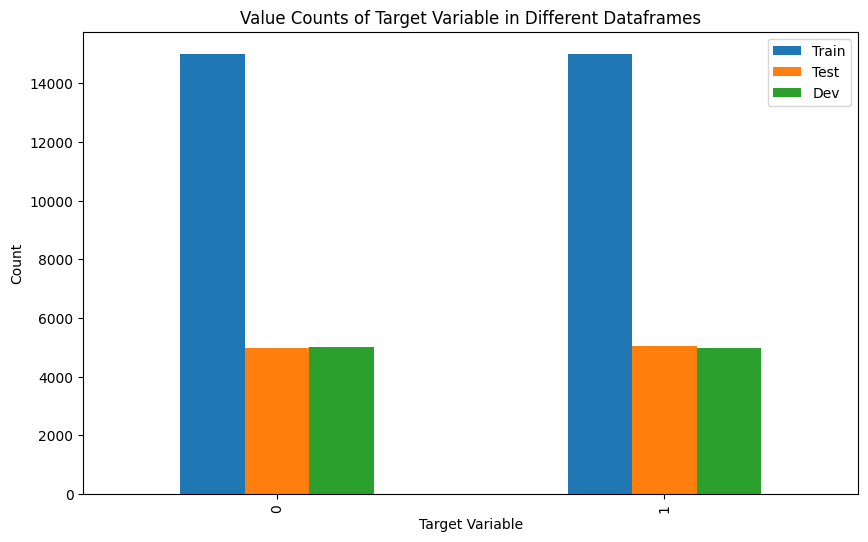

In [26]:
x_train = df_train.reviews
y_train = df_train.sentiment

# Count the values of the ground truth (sentiments)
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
dev_counts = y_dev.value_counts()


# Create a DataFrame with the counts
counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts, 'Dev': dev_counts})

# Plot the bar plot
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Value Counts of Target Variable in Different Dataframes')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()


## Comments

As we can observe via the above results we have very well balanced classes, thus we can proceed to the preprocessing of our data. 

## Plot the size of eact text for every set

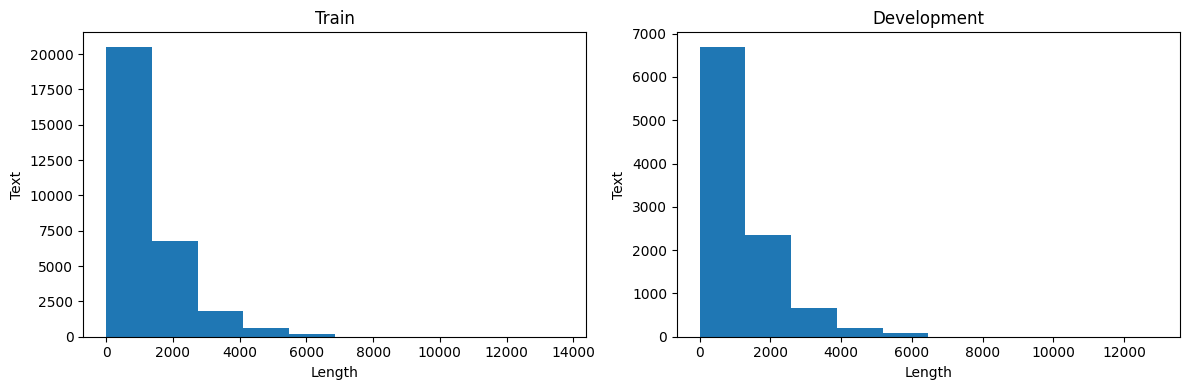

In [27]:
# Function to plot text lengths
def plot_text_lengths(ax, texts, title):
    text_lengths = [len(text) for text in texts]
    ax.hist(text_lengths)
    ax.set_xlabel('Length')
    ax.set_ylabel('Text')
    ax.set_title(title)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for texts1
plot_text_lengths(ax1, x_train, 'Train')

# Plot for texts2
plot_text_lengths(ax2, x_dev, 'Development')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Preprocessing

In [30]:
# Imports we need for preprocessing
import re
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

# Import stop words for preprocessing
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [42]:
def preprocess(contents):
  """
    Preprocesses a list of texts by removing non-word characters, single characters, extra spaces,
    converting to lowercase, splitting into words, lemmatizing, and reconstructing the documents.

    Parameters:
    - contents (list): A list of texts to be preprocessed.

    Returns:
    - pd.Series: A Pandas Series containing preprocessed documents.
    """

  docs = []

  for doc in contents:

      # Remove non-word (special) characters such as punctuation, numbers etc
      document = re.sub(r'\W', ' ', str(doc))

      # Remove HTML <BR>
      document = re.sub(r'\s+br\s+',' ', str(document))

      # Remove all single characters
      document = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', document)

      # Substitute multiple spaces with single space
      document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

      # Convert to Lowercase
      document = document.lower()

      # Split the document based on whitespaces (--> List of words)
      word_list = document.split()

      word_list = [word for word in word_list if word not in (stop_words)]

      # Lemmatization
      word_list = [stemmer.lemmatize(word) for word in word_list]

      # # Reconstruct the document by joining the words on each whitespace
      # document = ' '.join(word_list)

      # Append all documents into a list 'docs'
      docs.append(document)
  return pd.Series(docs)

In [45]:
# Preprocess texts
x_train = preprocess(x_train)
x_dev = preprocess(x_dev)
x_test = preprocess(x_test)

## Example of the processed text

In [81]:
# Example of a preprocessed text
print(f'The non processed text:\n {df_train.reviews.iloc[10]}')
print('------------------------------------------------------------------------------------')
print('VS')
print('------------------------------------------------------------------------------------')
print(f'The processed text:\n {x_train[10]}')

The non processed text:
 Having seen other Bollywood flicks with Salman Khan in them, I can say this is my favorite of the more recent ones. The songs are all quite fun, especially 'O Priya O Priya' which seems to have a nice mix of Beatles, Indian music and (dare I say this) a bit of Prince. The love stories are a bit more believable than, say, Chal Mere Bhai. The occasional focus on Prem's use of alcohol is at times troubling as it doesn't really seem to make sense to me, but it's played well by Khan--although his voice does become squeaky when he's portraying drunkenness.
------------------------------------------------------------------------------------
VS
------------------------------------------------------------------------------------
The processed text:
 seen bollywood flick salman khan say favorite recent one song quite fun especially priya priya seems nice mix beatles indian music dare say bit prince love story bit believable say chal mere bhai occasional focus prem use al

# TF-IDF Vectorization


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             max_features = 5000, sublinear_tf=True)

x_train_tfidf = vectorizer.fit_transform(x_train)
x_val_tfidf = vectorizer.transform(x_dev)
x_test_tfidf = vectorizer.transform(x_test)

print(x_train_tfidf.shape, type(x_train_tfidf))

(30000, 5000) <class 'scipy.sparse._csr.csr_matrix'>


## Dimensionality reduction via SVD method

In [83]:
# Reduce dimensionality using SVD 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_val_svd = svd.transform(x_val_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

print(x_train_svd.shape, type(x_train_svd))

(30000, 500) <class 'numpy.ndarray'>


## Baseline Models

### Logistic Regression baseline

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(x_train_svd, y_train)

# Validation set prediction
predictions = clf.predict(x_val_svd)
print(classification_report(y_dev, predictions))

# Test set prediction
predictions2 = clf.predict(x_test_svd)
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5015
           1       0.87      0.89      0.88      4985

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4964
           1       0.88      0.89      0.89      5036

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Building our model

In [139]:
# Import libraries
import keras
from keras.layers import Activation, Dropout, Dense, Input,BatchNormalization, Flatten, Embedding
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


def create_MLP_model(activation_dense_layers):
    """
    Create a deep feed forward network with Dense layers
    Add techniques such as dropout and Batch Normalization
    :param max_words: String (method of learning the parameters)
    :return: class keras.src.engine
    """
    model = Sequential()

    # First Layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    # Second Layer
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Third Layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))


    return model


### Custom Keras callback for calculating F1, precision, recall at the end of each epoch

In [140]:
class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict_proba = self.model.predict(self.validation_data[0])
        val_predict = (val_predict_proba > 0.5).astype(int)  # Convert probabilities to classes

        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, average="binary")
        _val_recall = recall_score(val_targ, val_predict, average="binary")
        _val_precision = precision_score(val_targ, val_predict, average="binary")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))


In [144]:
adam = Adam(learning_rate = 0.00003)

model = create_MLP_model('relu')
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=["accuracy"]
    )

# Build the model and print the structure of our model before training
model.build(x_train_svd.shape)  # We need to build our model in order to print the structure
print(model.summary())

# Add an early stopping callback to stop the epochs when we catch the best validation loss
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore best model weights when early stopping is triggered
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_loss',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Start our training
history = model.fit(
    x_train_svd,
    y_train,
    validation_data=(x_val_svd, y_dev),
    batch_size=128,
    epochs=200,
    shuffle=True,
    callbacks=[Metrics(valid_data=(x_val_svd, y_dev)), 
               early_stopping_callback,
               MLP_checkpoint]
)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (30000, 128)              64128     
                                                                 
 batch_normalization_88 (Ba  (30000, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_88 (Dropout)        (30000, 128)              0         
                                                                 
 dense_119 (Dense)           (30000, 512)              66048     
                                                                 
 batch_normalization_89 (Ba  (30000, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_89 (Dropout)        (30000, 512)            

## Visualize model's Training History

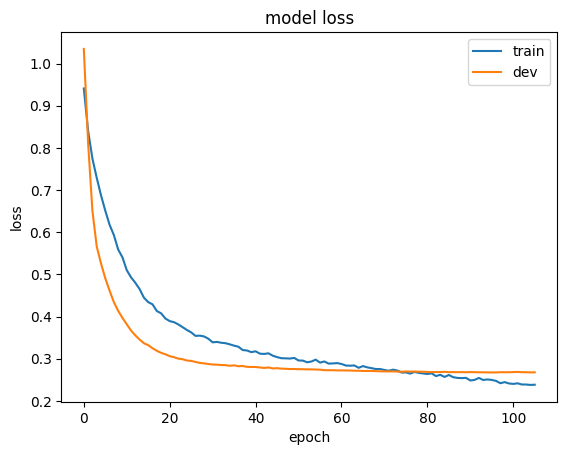

In [145]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [146]:
predictions = model.predict(x_test_svd)
# Assuming y_test is your ground truth labels
evaluation = model.evaluate(x_test_svd, y_test)
print('Test Set Evaluation:')
print(f"The loss of the test set is: {evaluation[0]*100: .3f}%\nThe accuracy of the test set is: {evaluation[1]*100: .3f}%")

313/313 [==============================] - 1s 2ms/step - loss: 0.2628 - accuracy: 0.8890
Test Set Evaluation:
The loss of the test set is:  26.283%
The accuracy of the test set is:  88.900%
